### Libraries

In [35]:
import torch
import pandas as pd
import torchvision
import numpy as np
# from torchvision.datasets import Flickr30k
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline



### Data


In [36]:
train=  pd.read_csv('flickr30k_processed/train.csv')

In [49]:
train.iloc[1]['caption']

'Two young White males are outside near many bushes'

A man is wearing a rainbow colored necklace and smiling


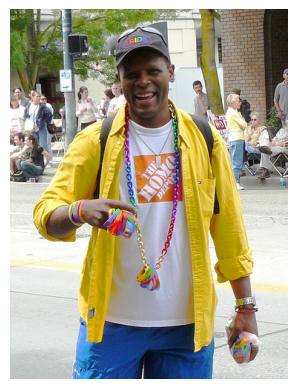

In [60]:
#random_impage
np.random.seed(11739391)
ids = [i for i in range(len(train)-1)]
def plot_random_image(ids):
    random_id = np.random.choice(ids)
    img_path = 'flickr30k_processed/' +train.iloc[random_id]['image']
    I = io.imread(img_path)
    print(train.iloc[random_id]['caption'])
    plt.imshow(I)
    plt.axis('off')
    plt.show()

plot_random_image(ids)

A boy wearing his school band uniform is standing holding his trumpet


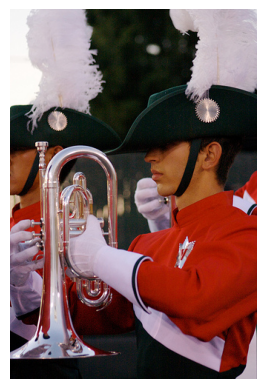

In [61]:
plot_random_image(ids)

A man watches his yellow dog hunt for something from on top of a fallen tree


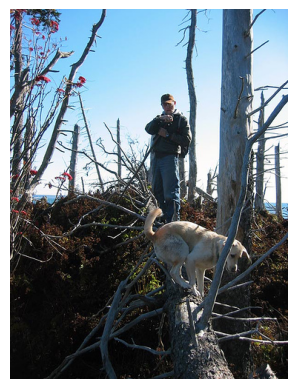

In [62]:
plot_random_image(ids)